# Import necessary libraries


In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


# Preprocess the image
* Converts the image to grayscale and applies binary thresholding.
* This helps in isolating the bubbles or marked areas.


In [2]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    return gray, thresh


# Find the largest contour
* Finds the largest contour in the thresholded image.
* This is assumed to be the boundary of the answer sheet.


In [3]:
def find_largest_contour(thresh):
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    return max(contours, key=cv2.contourArea)


# Warp the image
* Warps the image to a top-down view using the largest contour.
* This corrects any perspective distortion.


In [4]:
def warp_image(image, contour):
    
    # Get the minimum area rectangle that bounds the contour
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = box.astype(np.int32)  

    # Order the points in the rectangle
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]  
        rect[2] = pts[np.argmax(s)]  
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]  
        rect[3] = pts[np.argmax(diff)]  
        return rect

    src_corners = order_points(box)

    # Calculate the width and height of the rectangle
    width = int(np.linalg.norm(src_corners[0] - src_corners[1]))
    height = int(np.linalg.norm(src_corners[0] - src_corners[3]))
    output_size = (width, height)

    # Define the destination corners for the top-down view
    dst_corners = np.array([
        [0, 0],
        [output_size[0] - 1, 0],
        [output_size[0] - 1, output_size[1] - 1],
        [0, output_size[1] - 1]
    ], dtype="float32")

    # Compute the perspective transform matrix and apply it
    M = cv2.getPerspectiveTransform(src_corners, dst_corners)
    warped = cv2.warpPerspective(image, M, output_size)

    return warped


# Split the warped image
* Splits the warped image into a grid of boxes based on the number of questions and choices.
* Each box corresponds to a specific question and choice.


In [5]:
def split_into_boxes(image, num_rows, num_cols):
    
    height, width = image.shape
    box_height, box_width = height // num_rows, width // num_cols
    boxes = []
    for i in range(num_rows):
        for j in range(num_cols):
            top, bottom = i * box_height, (i + 1) * box_height
            left, right = j * box_width, (j + 1) * box_width
            box = image[top:bottom, left:right]
            boxes.append(box)
    return boxes


# Evaluate the answers
* Evaluates the answers by counting the number of marked pixels in each box.
* Determines the chosen answer for each question.


In [6]:
def evaluate_answers(boxes, num_rows, num_cols):
    
    counts = np.zeros((num_rows, num_cols))
    for i in range(num_rows):
        for j in range(num_cols):
            box = boxes[i * num_cols + j]
            counts[i, j] = np.count_nonzero(box)
    
    marked_answers = []
    for i in range(num_rows):
        min_count = np.min(counts[i])
        marked = []
        for j in range(num_cols):
            if counts[i, j] > min_count * 1.8:  # Threshold to detect marked bubbles
                marked.append(j + 1)  # Convert index to answer number (1-No.Answers)
        if len(marked) == 1:
            marked_answers.append(marked[0])  # Single answer
        else:
            marked_answers.append('N')  # 'N; For No answer or multiple answers
    return marked_answers


# Process the image
* Processes the image to extract and evaluate answers.
* Returns a table of questions and answers.


In [7]:
def process_image(image_path, num_questions, num_choices):
    """Process a single image to extract and evaluate answers."""
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image at {image_path}")
        return None

    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    gray, thresh = preprocess_image(image)

    # Display the grayscale image
    plt.figure(figsize=(6, 6))
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()

    # Display the thresholded image
    plt.figure(figsize=(6, 6))
    plt.imshow(thresh, cmap='gray')
    plt.title("Thresholded Image")
    plt.axis('off')
    plt.show()

    # Find the largest contour
    largest_contour = find_largest_contour(thresh)
    if largest_contour is None:
        print("Error: No contours found in the image.")
        return None

    # Draw the largest contour on the original image
    contour_image = image.copy()
    cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 3)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.title("Largest Contour")
    plt.axis('off')
    plt.show()

    # Warp the image to correct perspective
    warped = warp_image(image, largest_contour)

    # Display the warped image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.title("Warped Image")
    plt.axis('off')
    plt.show()

    # Convert the warped image to grayscale and threshold it
    warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    warped_thresh = cv2.threshold(warped_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Display the warped thresholded image
    plt.figure(figsize=(6, 6))
    plt.imshow(warped_thresh, cmap='gray')
    plt.title("Warped Thresholded Image")
    plt.axis('off')
    plt.show()

    # Split the image into answer boxes
    boxes = split_into_boxes(warped_thresh, num_questions, num_choices)

    # Display the first row of boxes 
    plt.figure(figsize=(10, 2))
    for i, box in enumerate(boxes[:num_choices]):
        plt.subplot(1, num_choices, i + 1)
        plt.imshow(box, cmap='gray')
        plt.title(f"Box {i + 1}")
        plt.axis('off')
    plt.suptitle("First Row of Boxes")
    plt.show()

    # Evaluate the answers
    marked_answers = evaluate_answers(boxes, num_questions, num_choices)

    # Create a table of questions and answers
    results = []
    for q_num, answer in enumerate(marked_answers, start=1):
        results.append({
            'Question': q_num,
            'Answer': answer
        })

    df = pd.DataFrame(results)

    return df


# Test cases


## Test case 1



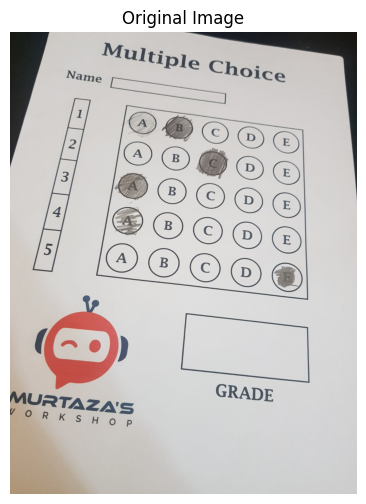

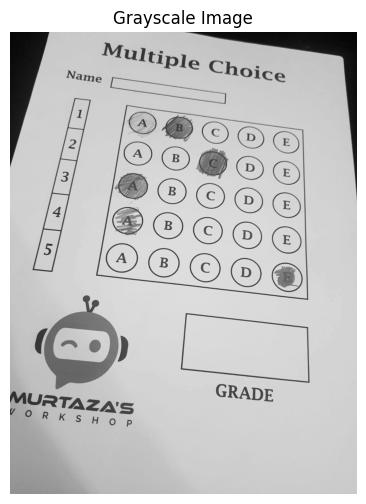

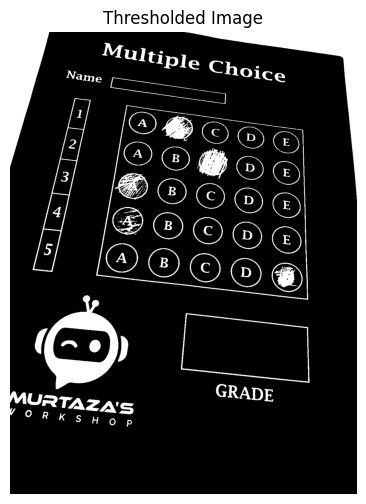

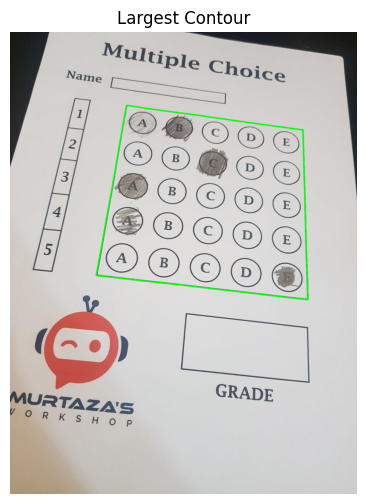

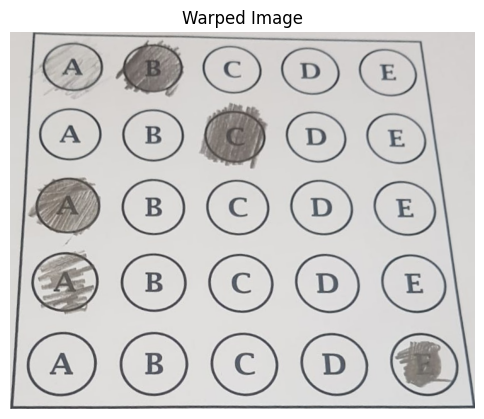

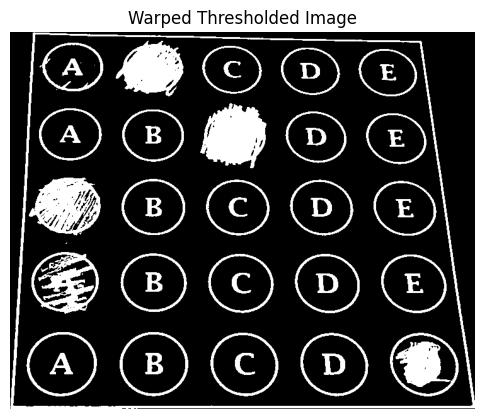

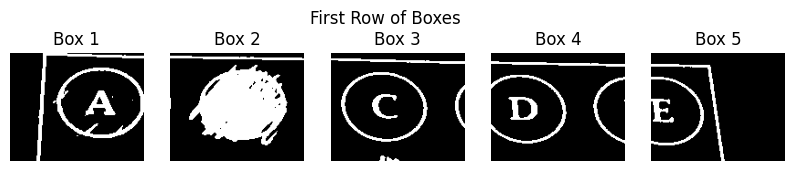

Results:
   Question  Answer
0         1       2
1         2       3
2         3       1
3         4       1
4         5       5


In [8]:
image_path = "images/6.jpg"  

# Number of questions and choices
num_questions = int(input('Enter NO.Qustions:'))
num_choices = int(input('Enter NO.Answers:'))


results_df = process_image(image_path, num_questions, num_choices)



if results_df is not None:
    print("Results:")
    print(results_df)
else:
    print("No results to display.")


## Test case 2



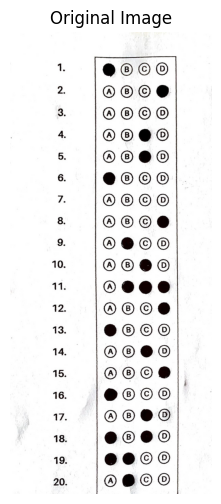

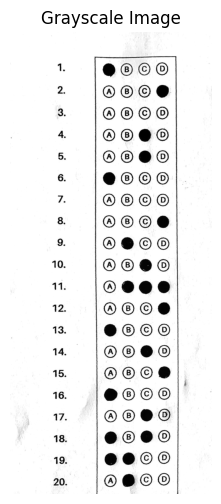

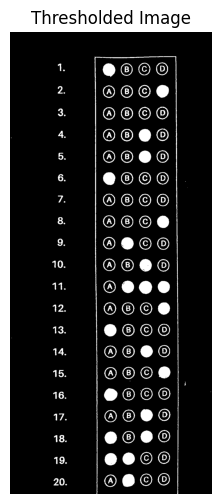

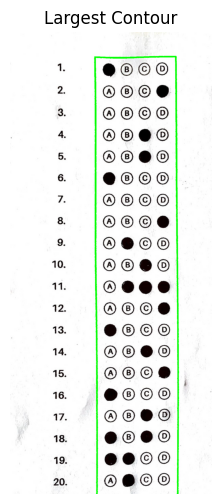

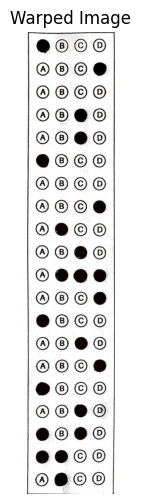

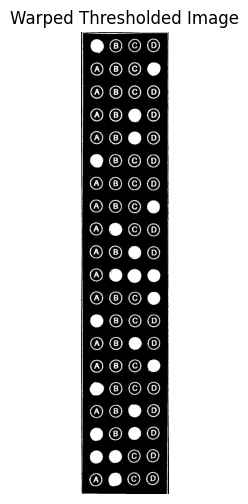

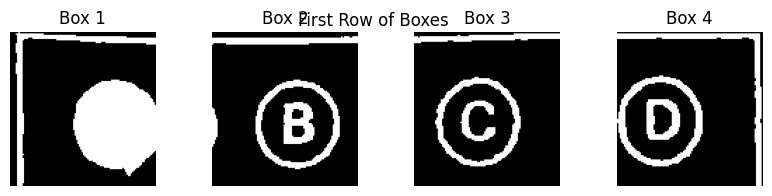

Results:
    Question Answer
0          1      1
1          2      4
2          3      N
3          4      3
4          5      3
5          6      1
6          7      N
7          8      4
8          9      2
9         10      3
10        11      N
11        12      4
12        13      1
13        14      3
14        15      4
15        16      1
16        17      3
17        18      N
18        19      N
19        20      2


In [9]:
image_path = "images/2.jpg" 


# Number of questions and choices
num_questions = int(input('Enter NO.Qustions:'))
num_choices = int(input('Enter NO.Answers:'))


results_df = process_image(image_path, num_questions, num_choices)


if results_df is not None:
    print("Results:")
    print(results_df)
else:
    print("No results to display.")


## Test case 3


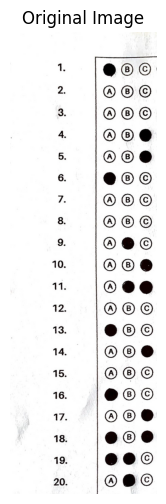

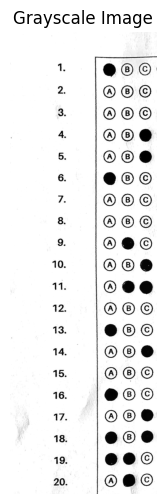

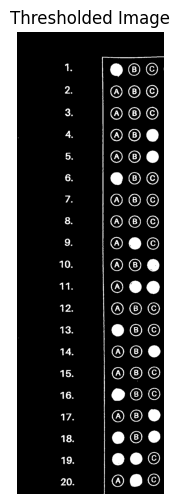

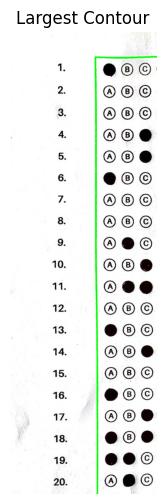

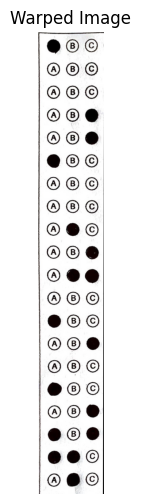

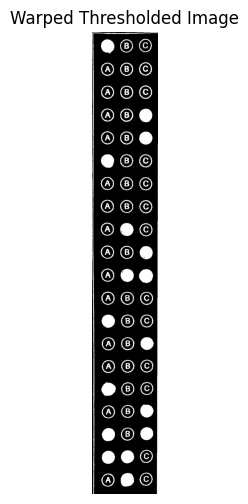

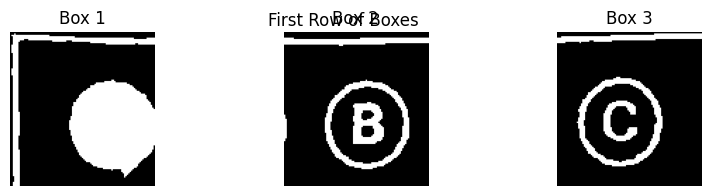

Results:
    Question Answer
0          1      1
1          2      N
2          3      N
3          4      3
4          5      3
5          6      1
6          7      N
7          8      N
8          9      2
9         10      3
10        11      N
11        12      N
12        13      1
13        14      3
14        15      N
15        16      1
16        17      3
17        18      N
18        19      N
19        20      2


In [10]:
image_path = "images/4.jpg"  

# Number of questions and choices
num_questions = int(input('Enter NO.Qustions:'))
num_choices = int(input('Enter NO.Answers:'))


results_df = process_image(image_path, num_questions, num_choices)


if results_df is not None:
    print("Results:")
    print(results_df)
else:
    print("No results to display.")
